In [1]:
import math
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal, fftpack, stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# Retrieve folders for transgenic strains

transgenics = os.listdir('CoBar-Dataset')
transgenics.remove('PR') # Control

In [3]:
def load_data(xp):
    '''
    Load data from an experiment (xp)
    
    Returns
    ------
    gen_dict
        General info on data (on/off periods, collisions...)
    
    data
        Raw data
    
    metadata
        Raw metadata
    '''
    
    # Load gendict
    genDict = np.load(f'CoBar-Dataset/{xp}/U3_f/genotype_dict.npy', allow_pickle=True).item()
    
    # Load data
    with open(f'CoBar-Dataset/{xp}/U3_f/{xp}_U3_f_trackingData.pkl', 'rb') as f:
        data = pickle.load(f)
    
    print(f'{xp} - Data dimension: {data.shape}')
    
    # Extract metadata
    metadata = np.array([list(item) for item in data.index.values])
    print(f'{xp} - Metadata dimension: {metadata.shape}')
    
    return genDict, data, metadata

In [4]:
def get_data_per_fly_per_xp():  
    '''
    Extract data for each fly in each experiment
    
    N: number of flies
    L: number of frames
    
    Returns
    ------
    dict_pretarsi_data
        A dictionary containing xy data for each pretarsus for each fly, size Lx12 for each fly
        key = experiment + fly index (according to tracking video)
    
    dict_metadata
        Corresponding metadata, size Lx6 for each fly
        key = experiment + fly index (according to tracking video)
    
    dict_pos_data
        Centroid xy data, size Lx2 for each fly
        key = experiment + fly index (according to tracking video)
    
    n_trial_data
        Get number of flies in each experiment
        key = experiment
    '''
    
    dict_pretarsi_data = {}
    dict_metadata = {}
    dict_pos_data = {}
    n_trial_data = {}
    
    stim_col = 1 # Metadata column with stimulation info ('on'/'off')
    xp_col = 3   # Metadata column with experiment info (time of experiment)
    fly_col = 4  # Metadata column with fly info (fly 0, 1 or 2) 
    
    for strain in transgenics:
        # Load data for given strain
        genDict, data, metadata = load_data(strain)
        
        # Extract pretarsi data
        pretarsi = ["LFclaw", "LHclaw", "LMclaw", "RFclaw", "RHclaw", "RMclaw"]
        pos = ["posx", "posy"]
        orientation = ["orientation"]
        pretarsi_data = data[pretarsi]   
        pos_data = data["center"][pos + orientation]
    
        # Gather all possible experiments and maximum number of flies
        xps = np.unique(metadata[:,xp_col])
        flies = np.unique(metadata[:,fly_col])
        
        n_trials = len(xps)*len(flies)

        for xp in xps:
            # Extract rows corresponding to current experiment
            xp_idx = np.where(metadata[:,xp_col] == xp)[0]
            
            # Extract corresponding metadata, pretarsi data and positional data
            xp_metadata = metadata[xp_idx]
            xp_pretarsi_data = pretarsi_data.iloc[xp_idx]
            xp_pos_data = pos_data.iloc[xp_idx]

            for fly in flies:
                # Extract rows corresponding to current fly
                fly_idx = np.where(xp_metadata[:,fly_col] == fly)[0]
                
                # Extract corresponding metadata and data for current fly
                xp_fly_metadata = xp_metadata[fly_idx]
                xp_fly_pretarsi_data = xp_pretarsi_data.iloc[fly_idx]
                xp_fly_pos_data = xp_pos_data.iloc[fly_idx]
                
                xp_fly_metadata = np.append(xp_fly_metadata, np.array(range(len(xp_fly_metadata))).reshape(-1,1), axis=1)
                
                
                # Sort timestamps, and re-arrange fly data for time stamps
                # Order = 'off0', 'on0', 'off1', 'on1', 'off2', 'on2', 'off3'
                if not(xp_fly_pretarsi_data.empty):
                    
                    dict_metadata[xp+fly] = np.array(sorted(xp_fly_metadata, key=lambda x: (int(x[stim_col][-1]), x[stim_col])))
                    idx_sort = np.array(list(map(int, dict_metadata[xp+fly][:,-1])))
                    dict_pretarsi_data[xp + fly] = np.array(xp_fly_pretarsi_data)[idx_sort,:] * 38/832                    
                    dict_pos_data[xp + fly] = np.array(xp_fly_pos_data)[idx_sort,:]
                    
                    # Only convert x, y pos positions to mm
                    dict_pos_data[xp + fly][:,:2] *= 38/832
                else:
                    n_trials -= 1
            
        n_trial_data[strain] = n_trials
        
        print(f'{strain}: {n_trials} trials')
    
    return dict_pretarsi_data, dict_metadata, dict_pos_data, n_trial_data

In [5]:
raw_pretarsi_data, raw_metadata, _, n_trial_data = get_data_per_fly_per_xp()

MDN - Data dimension: (28770, 70)
MDN - Metadata dimension: (28770, 6)
MDN: 12 trials
SS01049 - Data dimension: (26385, 70)
SS01049 - Metadata dimension: (26385, 6)
SS01049: 11 trials
SS01054 - Data dimension: (31162, 70)
SS01054 - Metadata dimension: (31162, 6)
SS01054: 13 trials
SS01540 - Data dimension: (26361, 70)
SS01540 - Metadata dimension: (26361, 6)
SS01540: 11 trials
SS02111 - Data dimension: (26396, 70)
SS02111 - Metadata dimension: (26396, 6)
SS02111: 11 trials
SS02279 - Data dimension: (28776, 70)
SS02279 - Metadata dimension: (28776, 6)
SS02279: 12 trials
SS02377 - Data dimension: (28764, 70)
SS02377 - Metadata dimension: (28764, 6)
SS02377: 12 trials
SS02608 - Data dimension: (28740, 70)
SS02608 - Metadata dimension: (28740, 6)
SS02608: 12 trials
SS02617 - Data dimension: (26355, 70)
SS02617 - Metadata dimension: (26355, 6)
SS02617: 11 trials


In [6]:
# Some keys to test
mdn = '200206_1539540'
turn = '200212_1620432'

In [7]:
def findOnPeriods(key, raw_metadata, display=False):
    '''
    Find On-Stimulation periods for a given experiment
    
    Parameters
    ------
    key
        Experiment key
    
    raw_metadata
        Raw metadata for each fly in each experiment
    
    display
        If true, displays on-stimulation intervals
    
    Returns
    ------
    numpy.ndarray
        All frames where the stimulation was ON
    '''
    
    metadata = raw_metadata[key]
    on_periods = ['on0', 'on1', 'on2']

    on_intervals = []

    for p in on_periods:
        start_period = np.where(metadata[:,1] == p)[0][0]
        end_period = np.where(metadata[:,1] == p)[0][-1]
        on_intervals.extend(list(range(start_period, end_period)))
        if display:
            print(f'{p}: {[start_period, end_period]}')
    return np.array(on_intervals)

In [8]:
def findStimulationData(raw_pretarsi_data, raw_metadata):
    '''
    Extract data where the stimulation was ON
    
    raw_pretarsi_data
        Raw xy data for each pretarsus, size Lx12 for each fly
    
    raw_metadata
        Corresponding metadata, size Lx6 for each fly
    
    Returns
    ------
    stim_data
        XY stimulation data for each pretarsus, size lx12 for each fly, l < L
    '''
    stim_data = {}
    
    for key, data in raw_pretarsi_data.items():
        on_idxs = findOnPeriods(key, raw_metadata)
        
        stim_data[key] = data[on_idxs,:]
        
    return stim_data

In [160]:
def dict2array(stim_data, nCoords=2):
    '''
    Build array from dictionary data containg stimulation xy positions for each fly
    
    stim_data
        Dictionary of "on" xy data for each fly
    
    nCoords
        Parameter to adjust size of matrix
        nCoords = 2 if no wavelet transformation is applied
        nCoords = 40 else
    
    Returns
    stim_array
        Transformation of stim_data into a numpy array: size Nx(l*K)
        N: number of flies
        l: number of on-stimulation frames
        K: number of features
    '''
    
    nLegs = 6
    min_nFrames = stim_data[min(stim_data, key=lambda x: stim_data[x].shape[0])].shape[0]
    
    stim_array = np.zeros((len(stim_data), min_nFrames*nLegs*nCoords))
    
    for i, (key, data) in enumerate(stim_data.items()):
        stim_array[i,:] = data[:min_nFrames,:].flatten()
    
    return stim_array.reshape(len(stim_data)*min_nFrames, nLegs*nCoords), min_nFrames

In [11]:
def findWavelets(stim_data):
    '''
    Apply wavelet transformation
    
    We used 20 frequencies from 1 to 40 Hz, 40 being the Nyquist frequency (Frame rate: 80 fps)
    
    Parameters
    ------
    stim_data
        A dictionary with raw data for each fly
        key = experiment + fly index (according to tracking video)
    
    Returns
    ------
    wavelet_data
        A dictionary with wavelet transform of data for each fly
    '''
    
    wavelet_data = {}

    n_scales = 20
    fps = 80
    f_min = 1
    f_max = fps/2
    #logvar_thresh = -6.

    for (key, data) in stim_data.items():
        wavelet_data[key] = np.zeros((list(data.shape) + [n_scales]))

        # Wavelet transformation
        for i in range(data.shape[1]):
            sig = abs(signal.cwt(data[:,i], signal.morlet2, np.geomspace(f_min, f_max, n_scales)).T)

            wavelet_data[key][:,i,:] = sig

        wavelet_data[key] = wavelet_data[key].reshape(wavelet_data[key].shape[0], wavelet_data[key].shape[1]*wavelet_data[key].shape[2])

        # Frame-normalization
        for t in range(wavelet_data[key].shape[0]):
            wavelet_data[key][t,:] = wavelet_data[key][t,:]/(wavelet_data[key][t,:].sum())
    
    return wavelet_data

In [185]:
def runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, average=False):
    stim_data = findStimulationData(raw_pretarsi_data, raw_metadata)
    print(f'Stimulation data - number of flies: {len(stim_data)}')
    print(f'Dimension of an observation {stim_data[next(iter(stim_data))].shape} \n')
    
    if average:
        stim_data = averageStimDataPerStrain(stim_data, n_trial_data)
        print('Averaging fly data for each strain: Done')
        print(f'Stimulation data observations after averaging: {len(stim_data)}')
        print(f'Dimension of an observation {stim_data[next(iter(stim_data))].shape} \n')
    
    wavelet_data = findWavelets(stim_data)
    print('Wavelet transform: Done')
    print(f'Dimension of an observation {wavelet_data[next(iter(wavelet_data))].shape}')
    
    wavelet_array, min_nFrames = dict2array(wavelet_data, nCoords=40)
    print(f'Conversion to array - data shape: {wavelet_array.shape} \n')
    
    embedded_array = TSNE(n_components=2).fit_transform(wavelet_array)
    print(f'TSNE - data shape: {embedded_array.shape}')
    
    classes, strains, unique_classes = buildColorMap(n_trial_data, min_nFrames, average=average)
       
    ova_classes, ranges = buildOVAColorMaps(n_trial_data, classes, min_nFrames)
    
    buildJointPlot(embedded_array, classes, strains, unique_classes)
    
    buildStrainJointPlots(embedded_array, n_trial_data, ova_classes, ranges)

Stimulation data - number of flies: 105
Dimension of an observation (716, 12) 

Averaging fly data for each strain: Done
Stimulation data observations after averaging: 9
Dimension of an observation (704, 12) 

Wavelet transform: Done
Dimension of an observation (704, 240)
Conversion to array - data shape: (6336, 240) 

TSNE - data shape: (6336, 2)
1/9


IndexError: index 6336 is out of bounds for axis 0 with size 6336

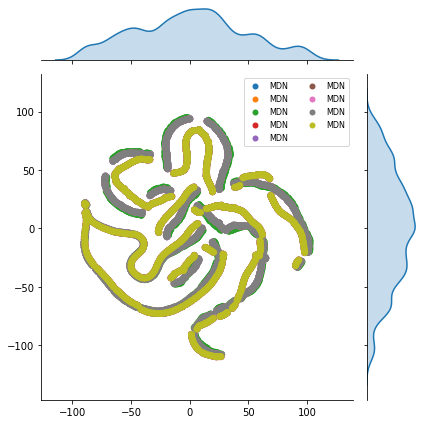

In [189]:
runPipeline(raw_pretarsi_data, raw_metadata, n_trial_data, average=True)

In [179]:
def buildColorMap(n_trial_data, min_nFrames, average=False):
    # Extract classes for each fly (1 = MDN, 2 = SS01049...)
    classes = [] # List of colours attributed to each strain for later plotting
    strains = [] # Strain corresponding to each fly
    unique_classes = [] # Unique version of 'classes'
    
    if average:
        nObservationsPerStrain = len(n_trial_data)*[min_nFrames]
    else:
        nObservationsPerStrain = [val*min_nFrames for val in n_trial_data.values()]

    for i, key in enumerate(n_trial_data.keys()):
        unique_classes.append(sns.color_palette()[i])

        for j in range(nObservationsPerStrain[i]):
            classes.append(sns.color_palette()[i])
            strains.append(key)
    
    classes = np.array(classes)
    strains = np.array(strains)
    unique_classes = np.array(unique_classes)    
    
    return classes, strains, unique_classes

In [10]:
stim_data = findStimulationData(raw_pretarsi_data, raw_metadata)

In [145]:
def averageStimDataPerStrain(stim_data, n_trial_data):
    stim_data_list = list(stim_data.values())
    
    nLegs = 6
    nCoords = 2
    min_nFrames = stim_data[min(stim_data, key=lambda x: stim_data[x].shape[0])].shape[0]
    
    start = 0
    
    average_stim_data = {}
    
    for i, (key, n_trials) in enumerate(n_trial_data.items()):
        strain_stim_data = stim_data_list[start:(start+n_trials)]
        
        strain_stim_array = np.zeros((len(strain_stim_data), min_nFrames, nLegs*nCoords))
    
        for j, data in enumerate(strain_stim_data):
            strain_stim_array[j,:,:] = data[:min_nFrames,:]
        
        #print(strain_stim_array.mean(0).shape)
        
        average_stim_data[key] = strain_stim_array.mean(0)
              
    return average_stim_data

In [187]:
def buildJointPlot(embedded_array, classes, strains, unique_classes, usingFullData=True, fname='full'):
    g = sns.jointplot(embedded_array[:,0], embedded_array[:,1], kind="kde")

    #Clear the axes containing the scatter plot
    g.ax_joint.cla()

    # set the current axis to be the joint plot's axis
    plt.sca(g.ax_joint)

    # plt.scatter takes a 'c' keyword for color
    # you can also pass an array of floats and use the 'cmap' keyword to
    # convert them into a colormap

    sc = plt.scatter(embedded_array[:,0], embedded_array[:,1], c = classes, label = strains)
    
    if usingFullData:
        lp = lambda i: plt.plot([], color = unique_classes[i], mec="none",
                                label=strains[i], ls="", marker="o")[0]

        handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
        plt.legend(handles=handles, ncol=2, prop={'size': 8})
    else:
        plt.title(fname)
    plt.tight_layout()
    plt.savefig(fname + '.png')

In [188]:
def buildStrainJointPlots(embedded_array, n_trial_data, ova_classes, ranges):
    for i, key in enumerate(n_trial_data.keys()):
    
        print(f'{i+1}/{len(list(n_trial_data.keys()))}')
        
        strain_embedding = embedded_array[ranges[i],:]
        ova_class = ova_classes[i,ranges[i],:]
        strain = strains[ranges[i]]
        
        buildJointPlot(strain_embedding, ova_class, strain, None, usingFullData=False, fname=key)

In [192]:
avg_classes, avg_strains, avg_unique_classes = buildColorMap(n_trial_data, min_nFrames, average=True)

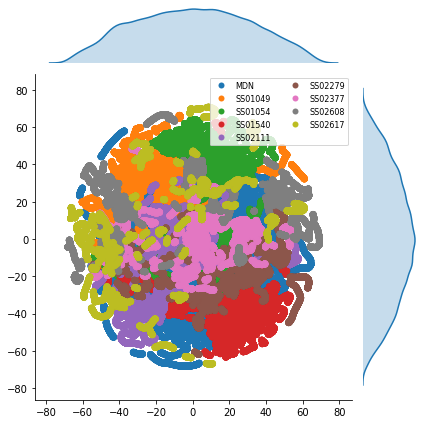

In [215]:
g = sns.jointplot(embedded_array[:,0], embedded_array[:,1], kind="kde")

#Clear the axes containing the scatter plot
g.ax_joint.cla()
g.ax_joint.scatter(embedded_array[:,0], embedded_array[:,1], c=classes, label=strains)

# set the current axis to be the joint plot's axis
plt.sca(g.ax_joint)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

# plt.scatter takes a 'c' keyword for color
# you can also pass an array of floats and use the 'cmap' keyword to
# convert them into a colormap

#sc = plt.scatter(embedded_array[:,0], embedded_array[:,1], c=classes, label=strains)
lp = lambda i: plt.plot([], color=unique_classes[i], mec="none",
                        label=list(n_trial_data.keys())[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
plt.legend(handles=handles, ncol=2, prop={'size': 8})
plt.tight_layout()

In [ ]:
# Extract classes for each fly (1 = MDN, 2 = SS01049...)

classes = [] # List of colours attributed to each strain for later plotting
strains = [] # Strain corresponding to each fly
unique_classes = [] # Unique version of 'classes'

for i, key in enumerate(n_trial_data.keys()):
    #print(i)
    #print(n_trial_data[key])
    #print(n_trial_data[key] * [i])
    unique_classes.append(sns.color_palette()[i])
    for j in range(min_nFrames * n_trial_data[key]):
        classes.append(sns.color_palette()[i])
        strains.append(key)
unique_classes = np.array(unique_classes)
classes = np.array(classes)
strains = np.array(strains)

In [12]:
wavelet_data = findWavelets(stim_data)

In [14]:
# Build array from wavelet data
stim_array = buildStimulationArray(wavelet_data, nCoords=40)
print(stim_array.shape)

In [16]:
# Embed stimulation array in a 2D space using TSNE
embedded_array = TSNE(n_components=2).fit_transform(stim_array)

In [19]:
min_nFrames = stim_data[min(stim_data, key=lambda x: stim_data[x].shape[0])].shape[0]

In [153]:
# Extract classes for each fly (1 = MDN, 2 = SS01049...)

classes = [] # List of colours attributed to each strain for later plotting
strains = [] # Strain corresponding to each fly
unique_classes = [] # Unique version of 'classes'

for i, key in enumerate(n_trial_data.keys()):
    #print(i)
    #print(n_trial_data[key])
    #print(n_trial_data[key] * [i])
    unique_classes.append(sns.color_palette()[i])
    for j in range(min_nFrames * n_trial_data[key]):
        classes.append(sns.color_palette()[i])
        strains.append(key)
unique_classes = np.array(unique_classes)
classes = np.array(classes)
strains = np.array(strains)

In [176]:
def buildOVAColorMaps(n_trial_data, classes, min_nFrames):

    ova_classes = []
    ranges = []

    start = 0

    for i, val in enumerate(n_trial_data.values()):
        nPoints = min_nFrames*val
        range_i = range(start, start+nPoints)
        
        ova_class = [classes[j,:] if j in range_i else np.zeros((3,)) for j in range(len(classes))]
        ova_classes.append(ova_class)

        start += nPoints

        ranges.append(range_i)
    
    return np.array(ova_classes), ranges

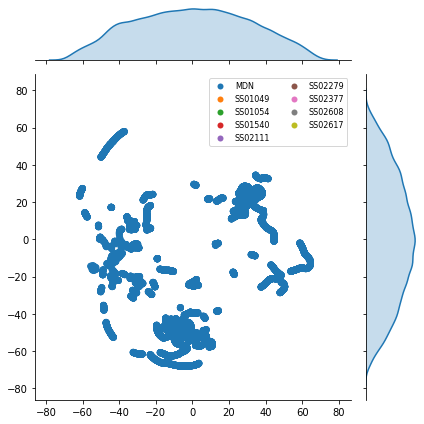

In [76]:
g = sns.jointplot(average_embedded_array[:,0], average_embedded_array[:,1], kind="kde")

#Clear the axes containing the scatter plot
g.ax_joint.cla()

# set the current axis to be the joint plot's axis
plt.sca(g.ax_joint)

# plt.scatter takes a 'c' keyword for color
# you can also pass an array of floats and use the 'cmap' keyword to
# convert them into a colormap
nPoints = min_nFrames*12

sub_embedding = embedded_array[ranges[i],:]


sc = plt.scatter(embedded_array[ranges,0], embedded_array[0:nPoints,1], c=binary_classes[0,0:nPoints,:], label=strains[0:nPoints])
lp = lambda i: plt.plot([], color=unique_classes[i], mec="none",
                        label=list(n_trial_data.keys())[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
plt.legend(handles=handles, ncol=2, prop={'size': 8})
plt.tight_layout()

1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
9/9


<Figure size 432x288 with 0 Axes>

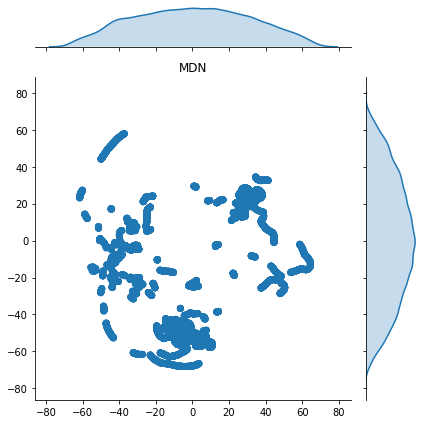

<Figure size 432x288 with 0 Axes>

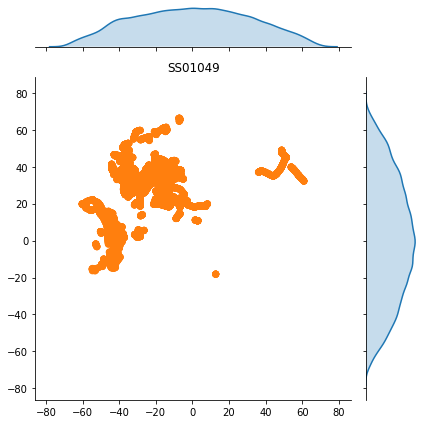

<Figure size 432x288 with 0 Axes>

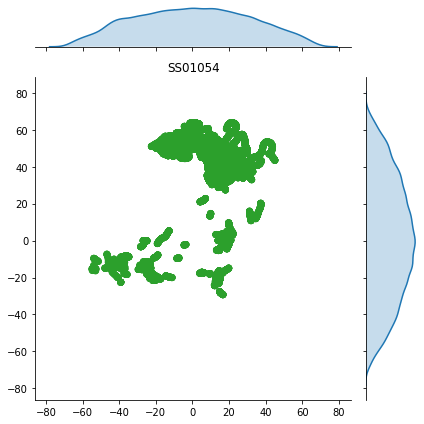

<Figure size 432x288 with 0 Axes>

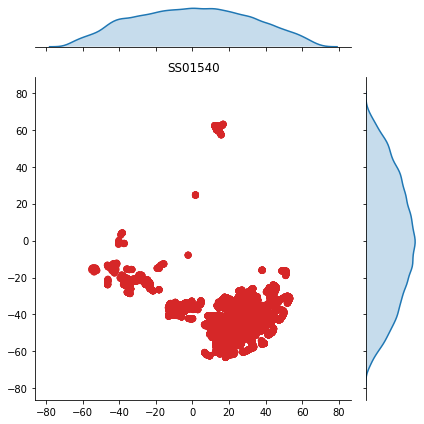

<Figure size 432x288 with 0 Axes>

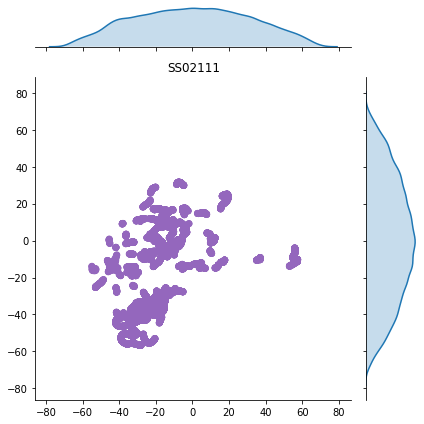

<Figure size 432x288 with 0 Axes>

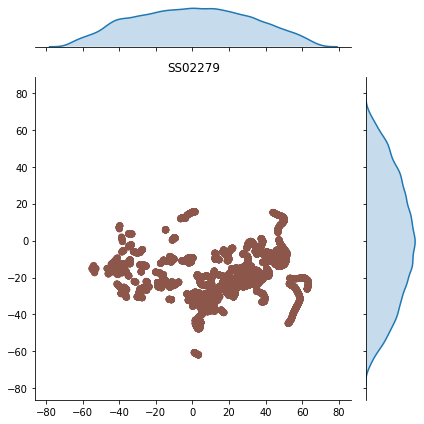

<Figure size 432x288 with 0 Axes>

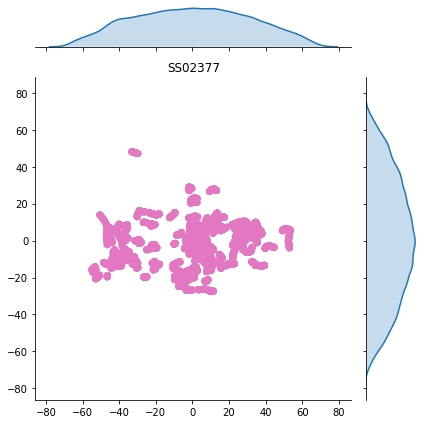

<Figure size 432x288 with 0 Axes>

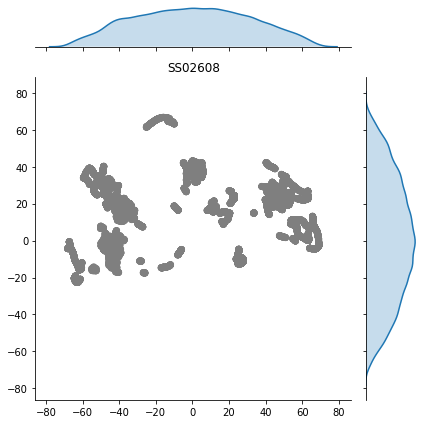

<Figure size 432x288 with 0 Axes>

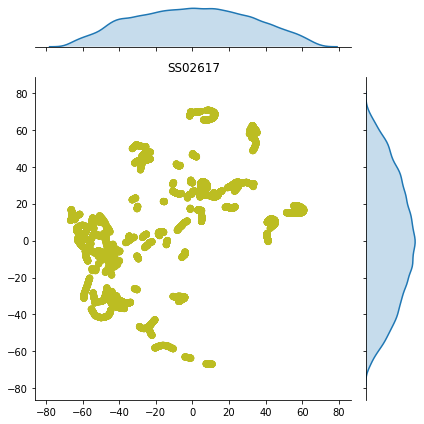

In [90]:
for i, key in enumerate(n_trial_data.keys()):
    
    print(f'{i+1}/{len(list(n_trial_data.keys()))}')
    
    plt.figure()    
    g = sns.jointplot(embedded_array[:,0], embedded_array[:,1], kind="kde")

    #Clear the axes containing the scatter plot
    g.ax_joint.cla()
    # Remove marginals
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()

    # set the current axis to be the joint plot's axis
    plt.sca(g.ax_joint)
    
    sub_embedding = embedded_array[ranges[i],:]
    
    sc = plt.scatter(sub_embedding[:,0], sub_embedding[:,1],
                     c=binary_classes[i,ranges[i],:], label=strains[ranges[i]])
    
    '''lp = lambda i: plt.plot([], color=unique_classes[i], mec="none",
                            label=list(n_trial_data.keys())[i], ls="", marker="o")[0]'''
    #handles = [lp(i) for i in np.arange(len(np.unique(strains)))]
    #plt.legend(handles=handles, ncol=2, prop={'size': 8})
    plt.title(key)
    plt.tight_layout()
